<a id="introduction"></a>
# Introduction

The biggest challenge eCommerce businesses face these days is how to reduce cart abandonment rates. In fact, the average cart abandonment rate across industries is really high. 

The marketing team would like to lower these number by identifying these users and giving them incentives so they finalize their carts.

* [Introduction](#introduction)
    - [Retrieving the data](#retrieving-the-data)
    - [Objective](#objective)   
* [1. User behavior](#user-behavior)
    - [Behavior according to events](#behavior-according-to-events)
    - [Event statistics](#event-statistics)
    - [Average session duration](#event-statistics)
    - [User statistics](#user-statistics)
    - [Product statistics](#product-statistics)
    - [Conclusion](#conclusion-1)
* [2. Boosting model](#boosting-model)
    - [Transforming the data](#transforming-the-data)
    - [Product information](#product-information)
    - [Session information](#session-information)    
    - [Feature engineering](#feature-engineering)
    - [Modeling with LightGBM](#modeling-with-lightlbm)
    - [Model evaluation](#model-evaluation)    
    - [Conclusion](#conclusion-2)
* [3. Optimization of hyperparameters](#optimization-of-hyperparameters)    
    - [Calibration curve](#calibration-curve)    
    - [Conclusion](#conclusion-3)    
* [4. Validation and interpretability](#optimization-of-hyperparameters)    
    - [Validate the model](#validate-the-model)
    - [Class densities](#class-densities)        
    - [ROC curve](#roc-curve)    
    - [Precision-recall curve](#precision-recall-curve)    
    - [Shapley values](#shapley-values)        
    - [SHAP](#SHAP)
    - [Conclusion](#conclusion-3)        
* [Conclusion](#conclusion)    

<a id="retrieving-the-data"></a>
## Retrieving the data

The dataset we are going to manipulate contains user events on an E-Commerce platform. For this, we have nearly 7 months of records where, for each event (product visited, added to cart, purchase, ...), we have the following information.

- __event_time__ : the event timestamp (UTC format).
- __event_type__: the type of event.
- __product_id__ : a unique identifier associated to the product.
- __category_id__: a unique identifier associated with the product category.
- __category_code__: a code associated with the product category.
- __brand__: the brand of the product.
- __price__: the price of the product.
- __user_id__: a unique identifier associated with the user.
- __user_session__: a temporary identifier for a user session in UUID format, created when the user arrives and kept until the user leaves the site.

The entire dataset totals nearly 50 GB of files. To do this, we will first study a sample.

For this project on Kaggle only 150 Mb will be used.

<a id="objective"></a>
## Objective

The objective for this project is to optimize targeted offers for marketing operations by proposing discounts for users during their shopping journey. \
To do this, __we are interested in knowing whether, during a session, a user will buy a product or not__, based on his or her known path so far.

We need to know more about the information we have at our disposal in order to build variables that will provide the maximum information to our predictive model.

<a id="user-behavior"></a>
# 1. User Behavior

In this first chapter, we will try to understand a little bit better the behavior of users.


<a id="#behavior-according-to-events"></a>

## Behavior according to events

In this part, we're going to look at whether there is a difference in behavior between views and purchases based on time. Let's start by loading the sample we have and converting some columns into specific types.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.units as munits
import matplotlib.dates as mdates
import seaborn as sns
import datetime

# Allows to display the x-axis more attractively
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

sns.set()

# Read the data
data = pd.read_csv('../input/ecommerce-user-actions/sample.csv')

# Convert event_time to datetime format
data["event_time"] = pd.to_datetime(data["event_time"])

data["event_day"] = data["event_time"].dt.day
data["event_hour"] = data["event_time"].dt.hour
data["event_minute"] = data["event_time"].dt.minute

In [2]:
print("Sample size:", data.shape[0])
print("Memory size: {:2.2f} Mb".format(data.memory_usage().sum() / 1e6))
data.head()

Sample size: 1244245
Memory size: 119.45 Mb


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_day,event_hour,event_minute
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,1,0,0
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,1,0,0
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,1,0,0
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,1,0,0
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1,0,0


This sample of raw data contains 1.24 million rows. Let's take a closer look at what information is present in this raw data. 

As mentioned before, we find the mentioned columns.

- First of all, two columns indicate the temporality and the type of event: it is the case of the **event_time** columns, indicating the date and the time when the event took place in UTC format (ISO 8601 standard), and **event_type** for the type of event.
- Then, some variables concern the user, notably **user_id** and **user_session**.
- Finally, the other information is related to the product concerned by the event: these are the **product_id**, **category_id**, **category_code**, **brand** and **price** columns.

<a id="event-statistics"></a>
## Event statistics
Let's study each variable, independently of the others with **univariate analyses**.

Date min: 2019-10-01 00:00:00
Date max: 2019-10-01 23:59:59


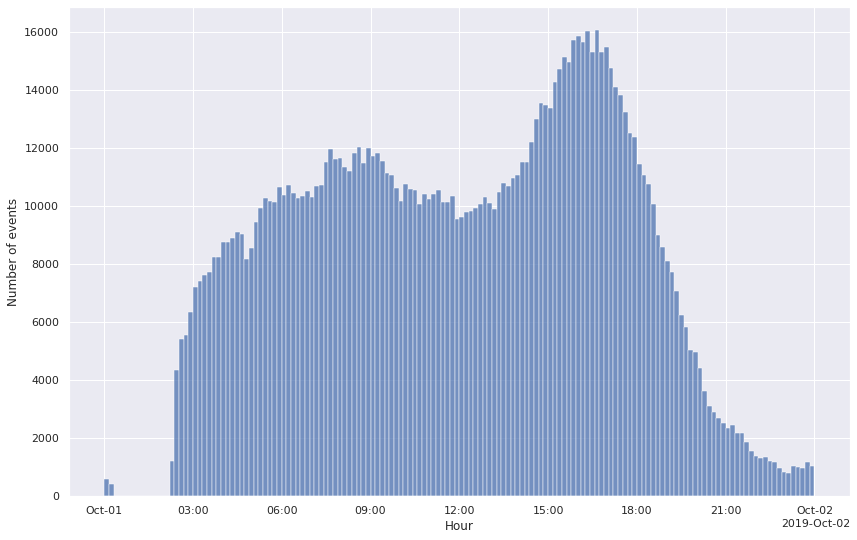

In [3]:
print("Date min: {}".format(data["event_time"].min()))
print("Date max: {}".format(data["event_time"].max()))

plt.figure(figsize=(14, 9))
sns.histplot(data["event_time"])
plt.xlabel("Hour")
plt.ylabel("Number of events")
plt.show()

As we can see the sample contains data from on one day only.

The traffic peaks between 16h and 18h before it drop drastically.

Now let's check the different type of events that have been registered.

In [4]:
print(data["event_type"].unique())

['view' 'purchase' 'cart']


The event type are described below:

- **view** - a user has viewed a product page
- **cart** - a user has added a product in the basket
- **purchase** - a user has purchased a product

Normally there are lot more 'views' than 'purhcases'.

The graphs below shows the distribution between the 3 event types.

view        0.971095
purchase    0.015517
cart        0.013388
Name: event_type, dtype: float64


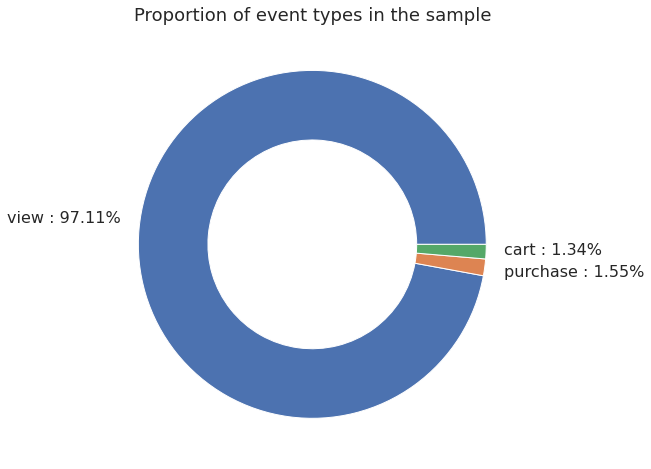

In [5]:
events_type_counts = data["event_type"].value_counts() / data.shape[0]
print(events_type_counts)

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(
    events_type_counts,
    wedgeprops=dict(width=0.4)
)

# Display text associated with wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    ax.annotate(
        "{} : {:2.2f}%".format(events_type_counts.index[i], events_type_counts[i] * 100),
        xy=(x, y), xytext=(1.1*np.sign(x), 1.4*y),
        fontsize=16,
        horizontalalignment=horizontalalignment)

ax.set_title("Proportion of event types in the sample", fontsize=18)
plt.show()

Of course, as this is an E-Commerce site, we expect to have an *over-representation* of **view** events compared to **purchase** events.

This graphs is important in case we decide to use a binary classification that will calculate the probability of the finalisation of the purchase. It shows that the data is __imbalanced__, which means one of the classes is over represented.

#### View vs. purchase

To compare the two distributions of events and purchases, histograms are a powerful visualization tool.

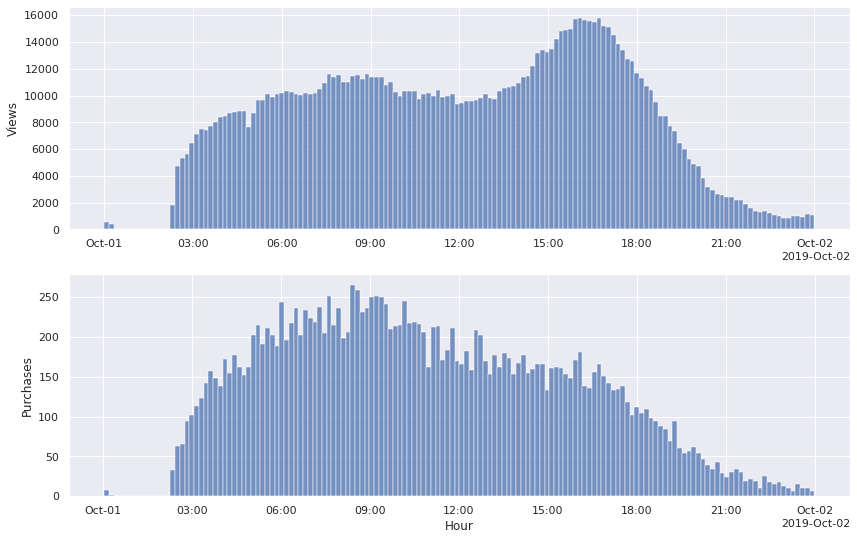

In [6]:
plt.figure(figsize=(14, 9))

plt.subplot(2, 1, 1)
sns.histplot(
    data.loc[data["event_type"] == "view", "event_time"],
    bins=150
)
plt.ylabel("Views")
plt.xlabel("")

plt.subplot(2, 1, 2)
sns.histplot(
    data.loc[data["event_type"] == "purchase", "event_time"],
    bins=150
)
plt.ylabel("Purchases")
plt.xlabel("Hour")
plt.show()


<a id="average-session-duration"></a>
## Average session duration
Now we are interested in knowing the average session length.

_Info:_ Sessions with only one page view will be removed

In [7]:
sessions_duration = data.groupby("user_session").agg({"event_time": [np.min, np.max]}).reset_index()
sessions_duration["amax"] = pd.to_datetime(sessions_duration["event_time"]["amax"])
sessions_duration["amin"] = pd.to_datetime(sessions_duration["event_time"]["amin"])
sessions_duration.columns = sessions_duration.columns.get_level_values(0)
sessions_duration["duration"] = (sessions_duration["amax"] - sessions_duration["amin"])

# Remove the sessions with only one page view.
sessions_duration = sessions_duration[sessions_duration["duration"].dt.seconds > 0]

# Average session duration
sessions_duration["duration"].mean()

Timedelta('0 days 00:08:55.572195227')

Let's visualize the distribution of session durations between 0-60 minutes.

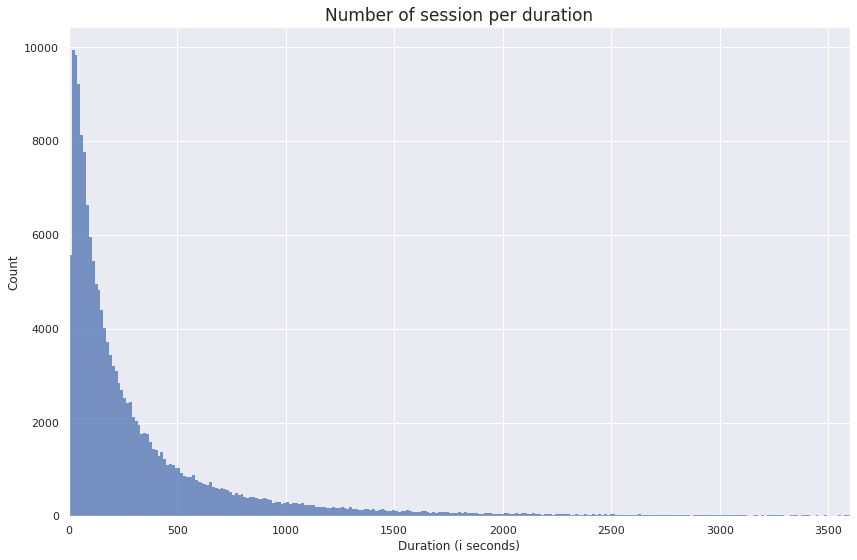

In [8]:
plt.figure(figsize=(14, 9))
sns.histplot(sessions_duration["duration"].dt.seconds)
plt.title("Number of session per duration", fontsize=17)
plt.xlabel("Duration (i seconds)")
plt.xlim(0, 3600)  # We display the histogram between 0 and 1h
plt.show()

Finally, we would like to know if users whose sessions lasts more than 1 hour buy more often than others.

**Procedure**

- Separate the users into user groups whose session is less than 1 hour and more than 1 hour.
- Calculate the proportion of purchases per user group.

In [9]:
# List long sessions
longer_sessions = sessions_duration[sessions_duration["duration"].dt.seconds > 3600]["user_session"].values

data_purchase = data.copy()
data_purchase['purchased'] = np.where(data_purchase['event_type'] == "purchase", 1, 0)
data_purchase['purchased'] = data_purchase \
    .groupby(["user_session"])['purchased'] \
    .transform("max")

print(data_purchase['purchased'].sample(5))

purchased_over_hour = data_purchase[data_purchase["user_session"].isin(longer_sessions)]["purchased"]

print("Proportion of users making a purchase for session duration > 1h :",
    round((purchased_over_hour.value_counts()[1] / purchased_over_hour.shape[0])*100, 2), "%"
)

print("Proportion of users making a purchase for session duration < 1h :",
    round((data_purchase["purchased"].value_counts()[1] /  data_purchase["purchased"].shape[0])*100, 2), "%"
)

941453    0
556091    1
96645     0
103425    1
505159    0
Name: purchased, dtype: int64
Proportion of users making a purchase for session duration > 1h : 11.01 %
Proportion of users making a purchase for session duration < 1h : 9.5 %


If we want to move towards a binary classification that will calculate the probability of q user finalizing a purchase, it is very important to know in advance if the dataset will be imbalanced, i.e. that one of the two classes will be overwhelmingly present (99% vs 1%).

<a id="#user-statistics"></a>
## User statistics

There are two important user identifiers in the dataset.

- The **user_id** column, gives a unique identifier for a user.
- The **session_id** column, in UUID format, gives the unique identifier for a user session.

<blockquote style='padding:20px'>A UUID is an identifier that uses time to ensure uniqueness (in the sense that it is very likely to have exactly two sessions that start at the same millisecond or even microsecond).</blockquote>

The user session is an important concept to master here: when a user visits the site, a session is created. This session is kept throughout the user journey on the site. As soon as the user leaves the platform, after a certain time, the session is stopped.

For example, if the user visits the site 3 times in one day, for example 10 minutes in the morning, 5 minutes in the afternoon and 20 minutes in the evening, then three sessions will be created during that day.

In [10]:
print("Unique number of users:", len(data["user_id"].unique()))
print("Number of sessions :", len(data["user_session"].unique()))

Unique number of users: 190188
Number of sessions : 268737


We have 268737 sessions for 190188 users: this means that there is a large proportion of users who have only one session.

Let's see what proportion of users have only one session in the sample.

#### Proportion of users by number of session

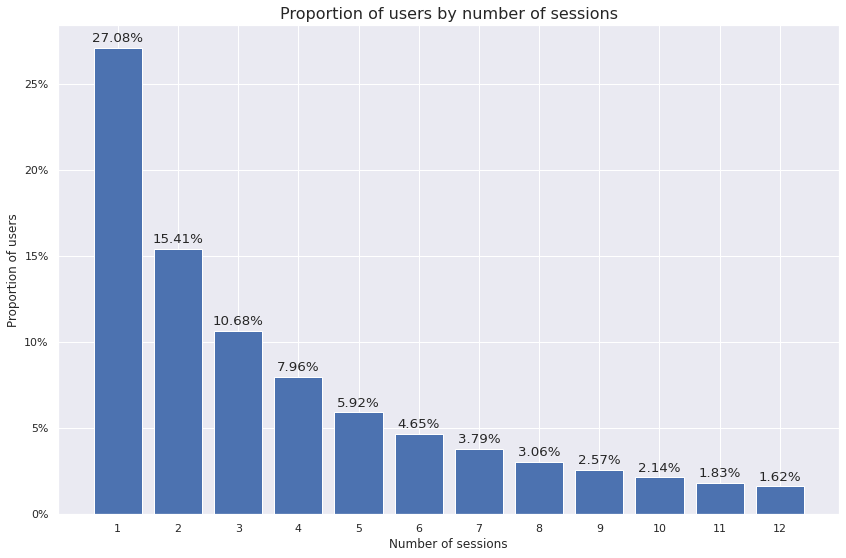

In [11]:
import matplotlib.ticker as mtick

num_sessions_per_user = data[["user_id", "user_session"]].groupby("user_id").count()["user_session"].value_counts().sort_values(ascending=False)

# Calculer la proportion
num_sessions_per_user /= num_sessions_per_user.sum()

plt.figure(figsize=(14,9))
n_bars = 12

rects = plt.bar(num_sessions_per_user[:n_bars].index, height=num_sessions_per_user[:n_bars])
for rect in rects:
    height = rect.get_height()
    # Ajouter du text à chaque bar
    plt.gca().annotate(
        # Convertir la proportion en percentage
        '{:2.2f}%'.format(height * 100),
        xy=(rect.get_x() + rect.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        fontsize=16 * 10 / n_bars,
        ha='center', va='bottom'
    )

plt.ylabel("Proportion of users")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.xticks(range(1, n_bars + 1))
plt.xlabel("Number of sessions")
plt.title("Proportion of users by number of sessions", fontsize=16)
plt.show()

We notice that more than 70% of the users have at least two sessions in the sample: it could therefore be interesting to use this information as an explanatory variable later on.

#### How many sessions resulted in a purchase of one of the visited products?

In [12]:
data_purchase = data.copy()
data_purchase['purchased'] = np.where(data_purchase['event_type'] == "purchase", 1, 0) # purchased = 1
data_purchase['purchased'] = data_purchase.groupby(["user_session"])['purchased'].transform("max")

print(data_purchase['purchased'].sample(5))

data_purchase["purchased"].value_counts() / data_purchase["purchased"].shape[0]

172900    0
787378    0
510493    0
167440    0
755083    0
Name: purchased, dtype: int64


0    0.904967
1    0.095033
Name: purchased, dtype: float64

This means that about 10% of the sessions end with at least one purchase of one of the visited products. This statistic informs us that the data set is not unbalanced between the two classes.

<a id="#product-statistics"></a>
## Product statistics

Let's now look at the products. In the **data_categories** DataFrame, we will calculate the number of events (views, adds to cart and purchases) per product category.

In [13]:
data_categories = data.copy()
data_categories["category"] = data_categories["category_code"].str.split(".", expand=True)[0]

for event_type in ["view", "cart", "purchase"]:
    data_categories["event_{}".format(event_type)] = np.where(data_categories["event_type"] == event_type, 1, 0)
    
data_categories = data_categories[["event_view", "event_cart", "event_purchase", "category"]].groupby("category").sum()
data_categories.head()

,event_view,event_cart,event_purchase
category,,,
accessories,7363,8,45
apparel,38314,0,170
appliances,136343,556,1953
auto,30937,161,226
computers,68970,157,804


To know which categories are the most visited, let's display the values on a bar chart.

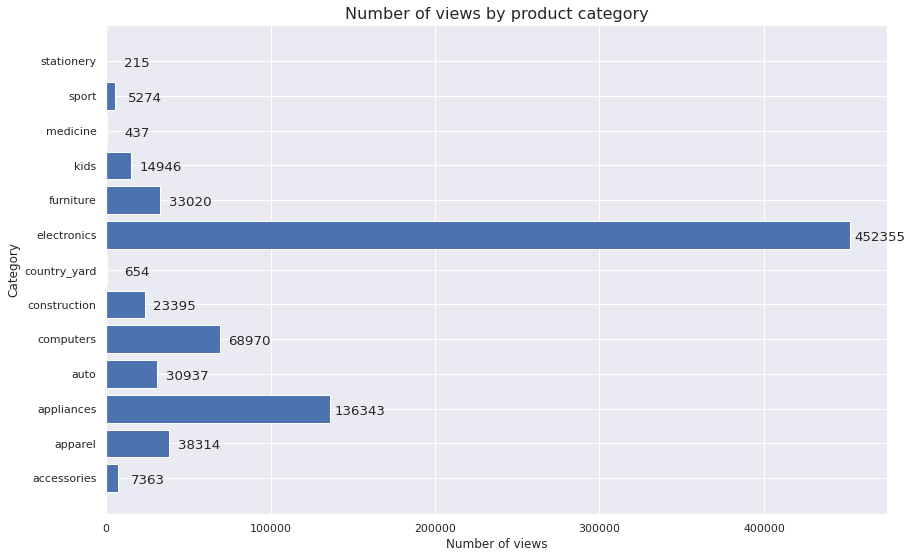

In [14]:
plt.figure(figsize=(14,9))

rects = plt.barh(data_categories.index, width=data_categories["event_view"])
for rect in rects:
    width = rect.get_width()
    plt.gca().annotate(
        '{}'.format(int(width)),
        xy=(width, rect.get_y()),
        xytext=(30, 5),
        textcoords="offset points",
        fontsize=16 * 10 / n_bars,
        ha='center', va='bottom'
    )

plt.ylabel("Category")
plt.xlabel("Number of views")
plt.title("Number of views by product category", fontsize=16)
plt.show()

What we observe is that the **electronics** category is the most visited one, with more than 450 000 views. On the other hand, others are very little visited like **stationery** or **medicine** with less than 500 views during a whole day.

Let's do the same thing for purchases.

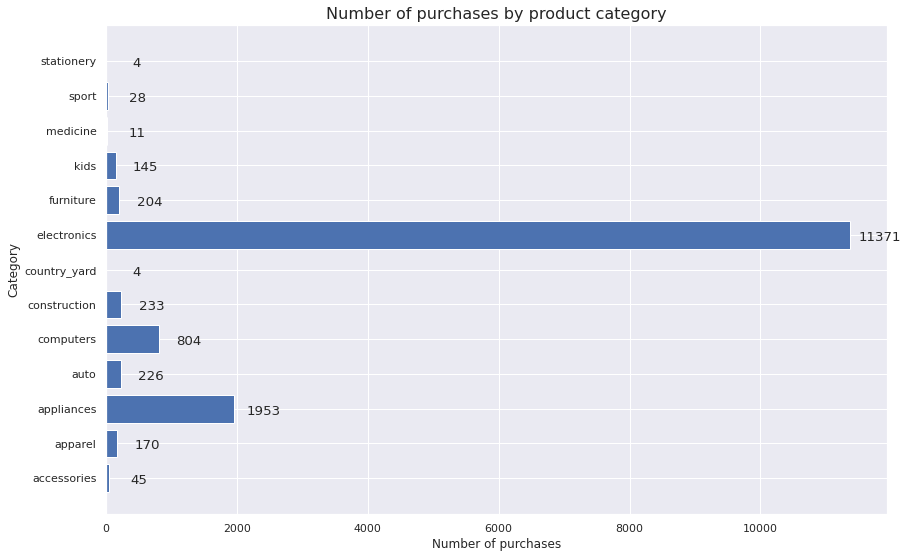

In [15]:
plt.figure(figsize=(14,9))

rects = plt.barh(data_categories.index, width=data_categories["event_purchase"])
for rect in rects:
    width = rect.get_width()
    plt.gca().annotate(
        '{}'.format(int(width)),
        xy=(width, rect.get_y()),
        xytext=(30, 5),
        textcoords="offset points",
        fontsize=16 * 10 / n_bars,
        ha='center', va='bottom'
    )

plt.ylabel("Category")
plt.xlabel("Number of purchases")
plt.title("Number of purchases by product category", fontsize=16)
plt.show()

Not surprisingly, the categories with the most views are also the ones with the most purchases. But let's take a look at the purchase/view ratios for each category.

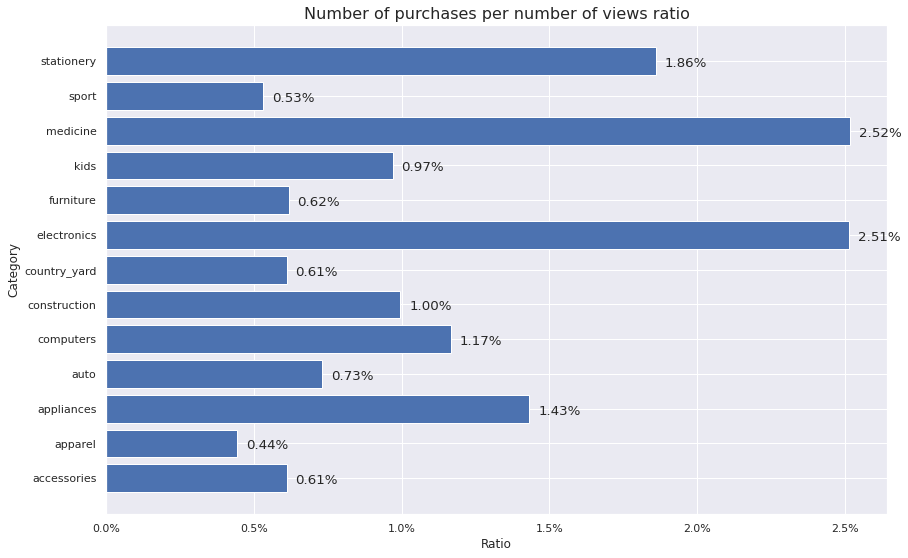

In [16]:
plt.figure(figsize=(14,9))

rects = plt.barh(data_categories.index, width=data_categories["event_purchase"] / data_categories["event_view"])
for rect in rects:
    width = rect.get_width()
    plt.gca().annotate(
        '{:2.2f}%'.format(width * 100),
        xy=(width, rect.get_y()),
        xytext=(30, 5),
        textcoords="offset points",
        fontsize=16 * 10 / n_bars,
        ha='center', va='bottom'
    )

plt.ylabel("Category")
plt.xlabel("Ratio")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))
plt.title("Number of purchases per number of views ratio", fontsize=16)
plt.show()

Surprisingly, while there are far fewer visits for **medicine** products than electronics (order x 10000 ), the former records the same proportion of purchases / views as the latter.

<a id="#conclusion-1"></a>
## Conclusion
From now on, we have a clearer idea about the data we are manipulating.

- User behavior cannot be reduced to a single event.
- Interactions between variables seem to be high.

From this knowledge, we will be able to implement a first algorithm with __LightGBM__.

<a id="#boosting-model"></a>
# 2. Boosting model

Now that we have more knowledge about the data, we can start by transforming the data and training a first model. Our choice is __LightGBM__, because of its training speed of and its performance that is close to XGBoost.

<a id="#transforming-the-data"></a>
## Transforming the data

Let's go back to the sample we studied before.

In [17]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_day,event_hour,event_minute
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,1,0,0
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,1,0,0
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,1,0,0
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,1,0,0
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1,0,0


As mentioned previously, we want to know if a user will buy a product during a session or not. Thus, our learning base will be made up of sessions where we know whether the user has bought this product or not.

Each observation of our learning base will have the following information.

- Information related to the product (number of views of the product in the session, category, product ID).
- Session information (duration in seconds, number of previous sessions, start time).

We will therefore transform the sample to obtain this information.

<a id="#product-information"></a>
## Product Information

According to our goal, our learning base will represent a set of sessions where, for each session and each product, the user has purchased (column "purchased" = 1) this product or not (column "purchased" = 0). We will therefore have to **aggregate the rows** having the same user session and for the same product.

Let's start by building the **purchased** column.

In [18]:
# We get the events whose user_session column is not null
# ~data["user_session"].isna() -> does not contain isna()
# The copy() method returns a new list, it does not modify the original list. If the original list is modified, events_per_session will not be modified.
# This would be the case if "=" is used -> events_per_session = data.loc[~data["user_session"].isna(), :]
events_per_session = data.loc[~data["user_session"].isna(), :].copy()

# We create a purchase column which is 0 or 1, depending on the event_type column
events_per_session['purchased'] = np.where(events_per_session['event_type'] == "purchase", 1, 0)

# We aggregate by session and by product to know if the latter has been purchased in the session
events_per_session['purchased'] = events_per_session \
    .groupby(["user_session", "product_id"])['purchased'] \
    .transform("max")

events_per_session.sample(n=5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_day,event_hour,event_minute,purchased
360157,2019-10-01 08:25:21,view,26025636,2053013562611204913,NaN,NaN,2.10,516415592,d8fdc423-ec13-48db-bfb8-6ccbd8181bc1,1,8,25,0
32219,2019-10-01 03:10:44,view,1002544,2053013555631882655,electronics.smartphone,apple,464.08,555469518,ad9a2622-2551-42f2-a09b-db4fbf691e2b,1,3,10,0
629420,2019-10-01 12:23:43,view,1003942,2053013555631882655,electronics.smartphone,xiaomi,187.80,555622256,3ca88839-6ec0-4b3f-a282-97e603488f9d,1,12,23,0
250066,2019-10-01 06:52:18,view,28101496,2053013564918072245,NaN,erdenet,252.26,547880118,52062562-1d95-4a76-8594-15b0909ccc4a,1,6,52,0
874047,2019-10-01 15:39:41,view,1004708,2053013555631882655,electronics.smartphone,huawei,154.07,555632522,0f454b6c-2d62-441b-a560-e21514fb5039,1,15,39,0


If the purchased column is 1, it means that during the session, the user has purchased the product.

Let's do the same thing for the number of views in the session by creating the column **num_views**.

In [19]:
# We determine how many times the user has seen products in the session
events_per_session['num_views_session'] = np.where(events_per_session['event_type'] == "view", 1, 0)
events_per_session['num_views_session'] = events_per_session.groupby(["user_session"]) \
    ['num_views_session'].transform("sum")

# Determines how many times the user has seen a particular product in the session
events_per_session['num_views_product'] = np.where(events_per_session['event_type'] == "view", 1, 0)
events_per_session['num_views_product'] = events_per_session.groupby(["user_session", "product_id"]) \
    ['num_views_product'].transform("sum")

events_per_session.sample(n=5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_day,event_hour,event_minute,purchased,num_views_session,num_views_product
557413,2019-10-01 11:15:16,view,26401668,2053013563651392361,NaN,lucente,169.37,551391014,39dfead9-3daa-43c6-acbe-ae2f633e9428,1,11,15,0,34,1
276289,2019-10-01 07:16:00,view,6200950,2053013552293216471,appliances.environment.air_heater,willmark,20.57,524318253,a59682a8-ecf6-4a90-832b-ffbe84cadc36,1,7,16,0,4,1
622743,2019-10-01 12:17:13,view,2601779,2053013563970159485,NaN,artel,174.78,555621151,da197617-079e-44db-b5bd-bbfcc97d7baa,1,12,17,0,8,2
963098,2019-10-01 16:33:44,view,8900969,2053013553090134275,kids.toys,playlab,15.06,542224580,3294c0ff-ac08-446a-91a4-135d72b33d58,1,16,33,0,50,3
329021,2019-10-01 07:59:22,view,5701166,2053013553970938175,auto.accessories.player,NaN,136.40,552170824,7c399919-da58-432c-bbf0-d6bb2b21f07e,1,7,59,0,3,1


We will also perform a **split** on the **category_code** column to retrieve the category and sub-category of each product (if they exist).

In [20]:
events_per_session['category'] = events_per_session['category_code'].str.split(".",expand=True)[0].astype('category')
events_per_session['sub_category'] = events_per_session['category_code'].str.split(".",expand=True)[1].astype('category')

Finally, we convert the **event_time** column into a **datetime** object, which allows us to retrieve precisely the hour, minute and day of the week associated with the event.

In [21]:
events_per_session["event_time"] = pd.to_datetime(events_per_session["event_time"], utc=True)

events_per_session["hour"] = events_per_session["event_time"].dt.hour
events_per_session["minute"] = events_per_session["event_time"].dt.minute
events_per_session["weekday"] = events_per_session["event_time"].dt.dayofweek

<a id="#session-information"></a>   
## Session information

Now let's look at the sessions of each user. We'll start by determining the durations of each session. The easiest way to do this is to group the observations by **user_session**, then calculate the minimum and maximum of the **event_time** column.

In [22]:
# We calculate the minimum and maximum date of each session
sessions_duration = events_per_session \
    .groupby("user_session").agg(
        {"event_time": [np.min, np.max]}
    ).reset_index()

sessions_duration["amax"] = pd.to_datetime(sessions_duration["event_time"]["amax"])
sessions_duration["amin"] = pd.to_datetime(sessions_duration["event_time"]["amin"])
del sessions_duration["event_time"]

# The columns are flattened to level 0
sessions_duration.columns = sessions_duration.columns.get_level_values(0)

# We calculate the total duration, in seconds, of each TimeDelta
sessions_duration["duration"] = (sessions_duration["amax"] - sessions_duration["amin"]).dt.seconds
sessions_duration.head()

,user_session,amax,amin,duration
0,0000c738-9fbb-466a-906c-e3b2a62730da,2019-10-01 19:12:07+00:00,2019-10-01 19:08:39+00:00,208
1,00012d23-c857-40af-b8cb-ada787bc00cc,2019-10-01 15:49:51+00:00,2019-10-01 15:49:07+00:00,44
2,00016584-60b8-4d68-8b89-960b6a5cb750,2019-10-01 19:24:49+00:00,2019-10-01 19:24:49+00:00,0
3,00016bb9-b50d-4bcb-95d1-9c375f214c66,2019-10-01 09:52:14+00:00,2019-10-01 09:51:44+00:00,30
4,0001c1b8-85f4-46c6-837d-f5becd54f208,2019-10-01 22:27:58+00:00,2019-10-01 22:27:58+00:00,0


When duration = 0, only one event has been created, but without a second event that followed during the session.

Once calculated, we simply need to do a **join** with the **events_per_session** DataFrame, the result of which will be stored in the **dataset** data frame.

In [23]:
dataset = events_per_session \
    .sort_values("event_time") \
    .drop_duplicates(["event_type", "product_id", "user_id", "user_session"]) \
    .loc[events_per_session["event_type"].isin(["cart", "purchase"])] \
    .merge(
        sessions_duration[["user_session", "duration"]],
        how="left",
        on="user_session"
    )

dataset.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_day,...,event_minute,purchased,num_views_session,num_views_product,category,sub_category,hour,minute,weekday,duration
0,2019-10-01 00:02:14+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1,...,2,1,3,3,electronics,smartphone,0,2,1,76
1,2019-10-01 00:04:37+00:00,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,...,4,1,9,2,electronics,smartphone,0,4,1,547
2,2019-10-01 00:05:14+00:00,cart,5100816,2053013553375346967,NaN,xiaomi,29.51,550121407,6f623695-9581-4633-813f-825b8760c7ae,1,...,5,0,2,2,NaN,NaN,0,5,1,42
3,2019-10-01 00:06:02+00:00,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,1,...,6,1,1,1,NaN,NaN,0,6,1,120
4,2019-10-01 00:07:07+00:00,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1,...,7,1,1,1,furniture,bathroom,0,7,1,67


Note that here we use a **drop_duplicates** to remove duplicate rows: they correspond to the same product, event type, user, and session (for example, a user who visits the same product twice in a single session).

<blockquote style='padding:20px'>We already harvested this information above by calculating the number of views per session.</blockquote>

Another question that may prove interesting: has the user had other sessions before? For this, it is important to establish **an order relationship**, especially with **event_time**.


In [24]:
count_prev_sessions = dataset[["user_id", "user_session", "event_time"]] \
    .sort_values("event_time") \
    .groupby(["user_id", "user_session"]) \
    .first() \
    .reset_index()

# cumcount() allows to do a cumulative count of the lines: 0, 1, 2, 3, ...
count_prev_sessions["num_prev_sessions"] = count_prev_sessions \
    .sort_values("event_time") \
    .groupby("user_id") \
    .cumcount()

count_prev_sessions.sample(5)

,user_id,user_session,event_time,num_prev_sessions
11341,534452681,042235cf-a3cd-4a0a-a8e9-81d5efeac9dd,2019-10-01 10:05:34+00:00,0
4352,515244218,d2791dfa-7ced-4a6f-9711-5fb130c5186b,2019-10-01 18:32:08+00:00,0
2667,513799302,2e481229-56b8-4ae4-beed-89c3703a9b20,2019-10-01 15:06:55+00:00,0
7727,520134829,89c2e338-beab-4d9b-8d31-943f2af5c8a1,2019-10-01 16:01:29+00:00,0
19880,555604502,7fae8cd3-6222-4270-af17-65d1ef11096e,2019-10-01 12:03:32+00:00,1


As always, we perform a join with dataset.

In [25]:
dataset = dataset.merge(
    count_prev_sessions[["user_session", "num_prev_sessions"]],
    how="left",
    on="user_session"
)

One last piece of information that might also be useful is whether the user has already seen a particular product in a previous session. It is very similar to the previous transformation, except that the **product_id** and **user_id** must also be taken into account.

In [26]:
view_prev_session = dataset[["user_id", "user_session", "event_time", "product_id"]]
view_prev_session = view_prev_session \
    .sort_values("event_time") \
    .groupby(["user_id", "user_session", "product_id"]) \
    .first() \
    .reset_index()

# cumcount() permits to do a cumulative counter of the rows: 1, 2, 3...
view_prev_session["num_prev_product_views"] = view_prev_session \
    .sort_values("event_time") \
    .groupby(["user_id", "product_id"]) \
    .cumcount()

dataset = dataset.merge(
    view_prev_session[["user_session", "product_id", "num_prev_product_views"]],
    how="left",
    on=["user_session", "product_id"]
)

Finally, we will remove duplicate rows from the **user_session**, **product_id** and **purchased** columns, if for example a user has purchased the same product more than once (in which case the outcome would always be the positive class from the moment the product is purchased at least once).

In [27]:
dataset = dataset \
    .sort_values("event_time") \
    .drop_duplicates(["user_session", "product_id", "purchased"]) \
    .drop(["event_time", "event_type", "category_code", "category_id"], axis=1)

dataset.to_csv("dataset.csv", index=False)
dataset.head()

,product_id,brand,price,user_id,user_session,event_day,event_hour,event_minute,purchased,num_views_session,num_views_product,category,sub_category,hour,minute,weekday,duration,num_prev_sessions,num_prev_product_views
0,1004856,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1,0,2,1,3,3,electronics,smartphone,0,2,1,76,0,0
1,1002532,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,0,4,1,9,2,electronics,smartphone,0,4,1,547,0,0
2,5100816,xiaomi,29.51,550121407,6f623695-9581-4633-813f-825b8760c7ae,1,0,5,0,2,2,NaN,NaN,0,5,1,42,0,0
3,5100816,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,1,0,6,1,1,1,NaN,NaN,0,6,1,120,0,0
4,13800054,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1,0,7,1,1,1,furniture,bathroom,0,7,1,67,0,0


We can now check the proportion of the two classes present in the dataset.


In [28]:
print("Dataset size:", dataset.shape[0])
proportions = round(dataset["purchased"].value_counts() / dataset.shape[0] * 100, 2)
print("Proportions in %\n{}".format(proportions))

Dataset size: 22971
Proportions in %
1    78.08
0    21.92
Name: purchased, dtype: float64


Our dataset **is not unbalanced**, so there is no resampling to apply.

Let's save the data to a CSV file for later use.

In [29]:
dataset.to_csv("primary.csv", index=False)

<a id="#feature-engineer"></a>
## Feature engineering

Now that our data frame **dataset** contains the observations, we have to apply a **feature engineering** step to make the learning base numerically transformed and usable by our model. 

There are really only three columns to encode: brand, category and sub_category.

In [30]:
from sklearn.preprocessing import LabelEncoder

# The features are the learning base that are encoded numerically
features = dataset.drop(["user_id", "user_session"], axis=1).copy()

for label in ["category", "sub_category", "brand"]:
    features[label] = features[label].astype(str)
    features.loc[features[label] == 'nan', label] = "unknown"
    features.loc[:, label] = LabelEncoder().fit_transform(features.loc[:, label].copy())

features['weekday'] = features['weekday'].astype(int)
features.sample(5)

,product_id,brand,price,event_day,event_hour,event_minute,purchased,num_views_session,num_views_product,category,sub_category,hour,minute,weekday,duration,num_prev_sessions,num_prev_product_views
5061,1004957,668,348.53,1,5,59,1,2,2,7,29,5,59,1,161,0,0
11215,1005116,30,1052.79,1,8,54,1,2,2,7,29,8,54,1,168,0,0
3244,24200008,333,8.11,1,5,1,1,3,1,13,41,5,1,1,194,0,0
6577,1004720,291,130.62,1,6,43,1,4,2,7,29,6,43,1,109,0,0
22248,1002544,30,464.05,1,14,57,0,3,1,7,29,14,57,1,581,0,0


We can now see that all the columns are now numerical.

Let's check that there are no missing values, because that can create problems with boosting models.

In [31]:
features.isna().sum()

product_id                0
brand                     0
price                     0
event_day                 0
event_hour                0
event_minute              0
purchased                 0
num_views_session         0
num_views_product         0
category                  0
sub_category              0
hour                      0
minute                    0
weekday                   0
duration                  0
num_prev_sessions         0
num_prev_product_views    0
dtype: int64

From there, we will create the learning base (X, y) consisting of the features and then separate the base into two subsets.

In [32]:
from sklearn.model_selection import train_test_split

X = features.drop("purchased", axis=1)
y = features['purchased']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

X_train.head()

,product_id,brand,price,event_day,event_hour,event_minute,num_views_session,num_views_product,category,sub_category,hour,minute,weekday,duration,num_prev_sessions,num_prev_product_views
17020,4804056,30,161.93,1,11,44,1,1,7,1,11,44,1,21,1,0
2240,6200373,187,51.46,1,4,22,13,2,2,16,4,22,1,1061,0,0
1272,12701398,674,70.14,1,3,40,3,3,13,41,3,40,1,1218,0,0
9684,4803686,668,8.21,1,8,13,3,3,7,1,8,13,1,125,0,0
17778,1004858,543,133.81,1,12,11,11,2,7,29,12,11,1,12263,0,0


We will then save the generated data.

<blockquote style='padding:20px'>It is important to have consistency on the sets used to train the models and to evaluate them. This is why the data is saved to files.</blockquote>

In [33]:
X.to_csv("X.csv", index=False)
y.to_csv("y.csv", index=False)

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

<a id="#modeling-with-lightlbm"></a>
## Modeling with LightGBM

The algorithm we will use is **LightGBM** : it has the advantage of being faster than XGBoost while keeping similar performances.

<a href="#tree-creation"></a>
### Tree creation

Although similar, the main difference between LightGBM and XGBoost is the way the trees are built.

XGBoost applies a method called **level-wise tree growth**, where each tree is built level by level. Thus, XGBoost grows the first level (depth 1), and then grows the second level (depth 2) once the previous level has been expanded. This is a horizontal approach.

LightGBM applies a method called **leaf-wise tree growth**. Unlike the previous method, the pruning is not done according to the depth, but directly according to the leaves. Thus, LightGBM will spread each leaf vertically, without making sure that the relevant depth is fully spread. This can produce, for example, trees that are not balanced (hence the possibility of always adding the **max_depth** hyper-parameter).

<blockquote style='padding:20px'>If we didn't do tree pruning, the trees built with XGBoost and LightGBM would be identical.</blockquote>

One of the main reasons LightGBM is very often faster than XGBoost is due to the use of the leaf-wise method.

The most important hyperparameters for LightGBM are:

- **num_leaves** which controls the number of leaves (nodes) in each tree.
- **min_child_samples** specifies the number of observations in a leaf. This is an important hyper-parameter to avoid over-learning, especially when the number of leaves is high.
- **max_depth** to control the maximum depth of each tree.
- **n_estimators** to determine the number of trees to calibrate.
- **learning_rate** to specify the learning rate of each tree.

In [34]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import f1_score

Let's train a LightGBM classifier with the default settings. We will set up a __Repeated k-Fold__ to calculate scores on multiple instances of the model.

<blockquote style='padding:20px'>As a reminder, cross-validation is important here to ensure that the calculated score for a model is consistent.</blockquote>

In [35]:
# We repeat 3 times a 5-Fold
rep_kfold = RepeatedKFold(n_splits=4, n_repeats=3)

# The models hyperparameters
hyp_params = {
    "num_leaves": 60,
    "min_child_samples": 10,
    "max_depth": 12,
    "n_estimators": 100,
    "learning_rate": 0.1
}

We will leave the default settings of the LGBMClassifier object.

In [36]:
scores_train = []
scores_test = []
n_iter = 1
for train_I, test_I in rep_kfold.split(X):
    print("Iteration {} of k-Fold".format(n_iter))

    # We recover the indexes of the subsamples
    X_fold_train = X.iloc[train_I, :]
    y_fold_train = y.iloc[train_I]
    X_fold_test = X.iloc[test_I, :]
    y_fold_test = y.iloc[test_I]
    
    # We train a LightGBM with the default settings
    model = LGBMClassifier(**hyp_params, objective="binary", verbose=-1)
    model.fit(X_fold_train, y_fold_train)

    # We calculate the score of the model on the test
    scores_train.append(
        f1_score(y_fold_train, model.predict(X_fold_train))
    )
    scores_test.append(
        f1_score(y_fold_test, model.predict(X_fold_test))
    )
    n_iter += 1

Iteration 1 of k-Fold
Iteration 2 of k-Fold
Iteration 3 of k-Fold
Iteration 4 of k-Fold
Iteration 5 of k-Fold
Iteration 6 of k-Fold
Iteration 7 of k-Fold
Iteration 8 of k-Fold
Iteration 9 of k-Fold
Iteration 10 of k-Fold
Iteration 11 of k-Fold
Iteration 12 of k-Fold


Let's now look at the scores on the two subsets.

Mean Train score: 91.9%
Mean Test score: 87.9%


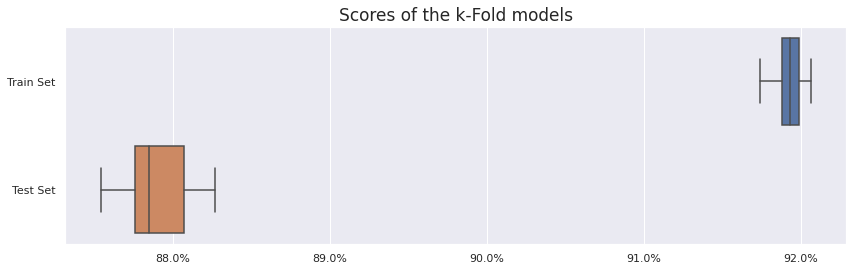

In [37]:
import matplotlib.ticker as mtick

print("Mean Train score: {:2.1f}%".format(np.mean(scores_train) * 100))
print("Mean Test score: {:2.1f}%".format(np.mean(scores_test) * 100))

scores = pd.DataFrame.from_dict({
    "Train Set": scores_train,
    "Test Set": scores_test
})

plt.figure(figsize=(14, 4))
sns.boxplot(data=scores, orient="h")
plt.title("Scores of the k-Fold models", fontsize=17)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
plt.show()

The mean scores for the for the training and test sets are 92.0% and 87.9% respectively. 

First, we notice from the graph that the variations in scores are small (a standard deviation of about 0.5% for the test set). \
Second, the difference between the two median scores is about 4%, which shows that there is no apparent overlearning of our models.

From these results, we can now calibrate a LightGBM on the pair (X_train, y_train).

In [38]:
model = LGBMClassifier(**hyp_params, objective="binary", verbose=-1)
model.fit(X_train, y_train)

LGBMClassifier(max_depth=12, min_child_samples=10, num_leaves=60,
               objective='binary', verbose=-1)

Let's also calculate the scores on the sets.

In [39]:
print("Train score: {:2.1f}%".format(f1_score(y_train, model.predict(X_train)) * 100))
print("Test score: {:2.1f}%".format(f1_score(y_test, model.predict(X_test)) * 100))

Train score: 92.0%
Test score: 87.6%


As expected, the scores are very similar to those obtained by the k-Fold model.

<a id="#model-evaluation"></a>   
## Model evaluation

The evaluation of the model is important, because it will allow us to ensure that the model is sufficiently efficient, while having a predictable behavior.

__Scores should not be the only metric to evaluate a Machine Learning model.__

In addition to the scores, the model must also satisfy other constraints. Indeed, in our marketing case study, we want to know if a customer will complete a purchase during his journey on the e-commerce platform.

The objective here is to **encourage the user to finalize his cart**. \
To do this, one method is to offer customized discounts to increase the probability that the user will complete a purchase. __It is therefore a binary classification problem.__ 

We can thus make two types of errors:

- A **false positive** consists in predicting that the user will buy the product when in reality, he will not finalize the purchase. In this case, offering a discount has little impact, since there is a strong chance that the user will not use it.

- A **false negative** consists in predicting that the user will not buy the product when in fact he will not finalize the purchase. In this second case, giving a discount to this user implies a loss of profit, since the user would have bought the product anyway, even without the discount code.

Here we see that the false negative has more impact in economic terms than the false positive. Indeed, it is better for a user to buy at a discounted price than not to buy a product. Conversely, it is better not to offer a discount to a user who would buy a product even without a discount code.

So our goal is to correctly detect false negatives, since they impact profits, as opposed to false positives.

### How to evaluate whether our model is more likely to produce false positives or false negatives?

To do this, we need to understand that in binary classification, the output of the model is not a class (or), but a probability (of being in each of the two classes).

Let's look at some statistics based on the confusion matrix:

- __Specificity__ represents the probability of predicting a non-purchase among users who did not purchase. TN / FP + TN

- __Sensitivity__ (or recall) represents the probability of predicting a purchase among users who have purchased. TP / TP + FN

- __Precision__ represents the probability of having users who have purchased among the users whose purchase was predicted. TN / TP + FP

The first two measures look at the rates among the theoretical knowledge of the behavior, while the last one looks at the rate among the predictions of the model.

We have said that it is important to have as few false negatives as possible: it is therefore the sensitivity (or recall) that should be observed. A low recall means that the share of false negatives is large, while a high recall means that the share of false negatives is close to.

Recall, by itself, cannot fully determine whether the model is performing well! A model may very well have very high recall, but very low precision. \
This is why we also use the F1 score, which involves both precision and recall.

$ Score_{F1} = 2 \times \frac {(Precision \times Recall)}{(Precision + Recall)} $

In [40]:
from sklearn.metrics import recall_score, precision_score

print("Precision Test : {:2.1f}%".format(precision_score(y_test, model.predict(X_test)) * 100))
print("Recall Test : {:2.1f}%".format(recall_score(y_test, model.predict(X_test)) * 100))

Precision Test : 80.5%
Recall Test : 96.2%


We have a very high recall, which means that there are few false negatives. 

On the other hand, the precision is not as good: there are more false positives, our model often tends to predict a purchase too much when it should not.

### How can we improve the accuracy?

The interest now is to determine which are the optimal hyperparameters that will allow us to obtain the best performance. For this, a common practice is **AutoML**, which consists in automating the training of the models.

And very often, in trying to determine the best hyperparameters, rather than using a grid search, **Bayesian methods** are used.

<a id="#conclusion-2"></a>
## Conclusion

We have just implemented our first predictive model on our data.

- The dataset was transformed to be sent to the predictive model.
- With a k-Fold, we trained a LightGBM.
- We measured the performance obtained.

<a id="#optimization-of-hyperparameters"></a>  
# 3. Optimization of hyperparameters

Bayesian optimization is a method for determining the optimal hyper-parameters of a model using Bayesian statistical tools. Their main interest, unlike grid searches, is to use the information acquired during the optimization to determine the next hyper-parameters to be tested.

What we will do:

- Discover the Bayesian approach to hyper-parameter optimization
- Launch a TPE search on LightGBM
- Calibrate a model on the best hyper-parameters

We will load the training set $(X,y)$ that will be used during the Bayesian optimization with k-Fold, and the training and test subsets to calibrate the model once the best hyperparameters are obtained.

In [41]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv").values.flatten()
y_test = pd.read_csv("y_test.csv").values.flatten()

Let's define the search space that will be used by the optimizer.

In [42]:
from lightgbm.sklearn import LGBMClassifier
from hyperopt import hp, tpe, fmin

MODEL_SPECS = {
    "name": "LightGBM",
    "class": LGBMClassifier,
    "max_evals": 20, # "max_evals": 20,
    "params": {
        "learning_rate": hp.uniform("learning_rate", 0.001, 1),
        "num_iterations": hp.quniform("num_iterations", 100, 1000, 20),
        "max_depth": hp.quniform("max_depth", 4, 12, 6),
        "num_leaves": hp.quniform("num_leaves", 8, 128, 10),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.3, 1),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "min_child_samples": hp.quniform("min_child_samples", 1, 20, 10),
        "reg_alpha": hp.choice("reg_alpha", [0, 1e-1, 1, 2, 5, 10]),
        "reg_lambda": hp.choice("reg_lambda", [0, 1e-1, 1, 2, 5, 10]),
    },
    "override_schemas": {
        "num_leaves": int, "min_child_samples": int, "max_depth": int, "num_iterations": int
    }
}

The list of LightGBM hyperparameters can be found in the documentation of the model.

To facilitate the maintenance of the code, we encapsulate the optimisation process in an **optimize_hyp** function which requires several arguments:

- __instance__ is the class inherited from BaseEstimator of scikit-learn to instantiate a model.
- __training_set__ is the training base $(X,y)$.
- __search_space__ is the search space for the optimizer.
- __metric__ is the metric to be used to calculate the score.
- __evals__ is the number of iterations of the optimizer.

<blockquote style='padding:20px'>In <b>hyperopt</b>, we seek to minimise an objective function: we must therefore return the additive inverse in the case where the metric used is a score.</blockquote>

In some cases, the hyperparameters of the search space are not always integers (10.0 instead of 10), which can generate errors. The **override_schemas** field contains a list of hyperparameters for which the conversion to integer is explicit.

In [43]:
from sklearn.model_selection import RepeatedKFold

def optimize_hyp(instance, training_set, search_space, metric, evals=10):
    # Function to be minimised (inverse of tau)
    def objective(params):
        for param in set(list(MODEL_SPECS["override_schemas"].keys())).intersection(set(params.keys())):
            cast_instance = MODEL_SPECS['override_schemas'][param]
            params[param] = cast_instance(params[param])
            
        # Repeat 3 times a 5-Fold
        rep_kfold = RepeatedKFold(n_splits=4, n_repeats=1)
        scores_test = []
        for train_I, test_I in rep_kfold.split(X):
            X_fold_train = X.iloc[train_I, :]
            y_fold_train = y.iloc[train_I]
            X_fold_test = X.iloc[test_I, :]
            y_fold_test = y.iloc[test_I]

            # A LightGBM is trained with the default settings
            model = LGBMClassifier(**params, objective="binary", verbose=-1)
            model.fit(X_fold_train, y_fold_train)

            # We calculate the score of the model on the test
            scores_test.append(
                metric(y_fold_test, model.predict(X_fold_test))
            )

        return np.mean(scores_test)

    return fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=evals)

By calling the **optimize_hyp** function, the best hyperparameters will be searched and returned once the optimization is completed. We will retrieve the optimal hyperparameters in the variable **optimum_params**.

In [44]:
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

optimum_params = optimize_hyp(
    MODEL_SPECS['class'],
    training_set=(X_train, y_train),
    search_space=MODEL_SPECS["params"],
    metric=lambda x, y: -f1_score(x, y), # Problème de minimisation = inverse du score
    evals=MODEL_SPECS["max_evals"],
)

100%|██████████| 20/20 [01:18<00:00,  3.95s/trial, best loss: -0.8800986033578682]


Let's display the optimal hyper-parameters.

In [45]:
optimum_params

{'colsample_bytree': 0.36347533383563746,
 'learning_rate': 0.2337369957127724,
 'max_depth': 6.0,
 'min_child_samples': 10.0,
 'num_iterations': 380.0,
 'num_leaves': 70.0,
 'reg_alpha': 5,
 'reg_lambda': 5,
 'subsample': 0.611823924169707}

Now that we know them, we can train a LightGBM with these hyperparameters.

In [46]:
# Each parameter whose schema is overloaded is cast to the correct type
for param in MODEL_SPECS['override_schemas']:
    cast_instance = MODEL_SPECS['override_schemas'][param]
    optimum_params[param] = cast_instance(optimum_params[param])

model = LGBMClassifier(**optimum_params)
model.fit(X_train, y_train)

from sklearn.metrics import recall_score, precision_score

print("F1 Score : {:2.1f}%".format(f1_score(y_test, model.predict(X_test)) * 100))
print("Precision : {:2.1f}%".format(precision_score(y_test, model.predict(X_test)) * 100))
print("Recall : {:2.1f}%".format(recall_score(y_test, model.predict(X_test)) * 100))

F1 Score : 87.1%
Precision : 81.0%
Recall : 94.2%


What is interesting here is that by trying to maximise the F1 score, we got a better recall, but the precision is lower.

<blockquote style='padding:20px'>It would be best not to use only recall to optimise the model: we would get a model with potentially poor precision.</blockquote>

In the end, compared to the non-optimized model, we have gained very little in terms of F1 Score, but we have better recall, which was the initial objective since it is mainly this metric that we need to maximize.

We will save the model in pkl format, which we will reuse to evaluate and interpret it.

In [47]:
import joblib

joblib.dump(model, "model.pkl")

['model.pkl']

<a id="#calibration-curve"></a>    
## Calibration curve

Calibration curves allow to compare the proportions of positively predicted observations and observations belonging to the positive class from the threshold defining the classifier frontier.
defining the frontier of the classifier.

Binary classification models does not return 1 or 0, but returns a probability between 0 and 1 (alpha).

Let's look at the calibration curve of our optimized model.

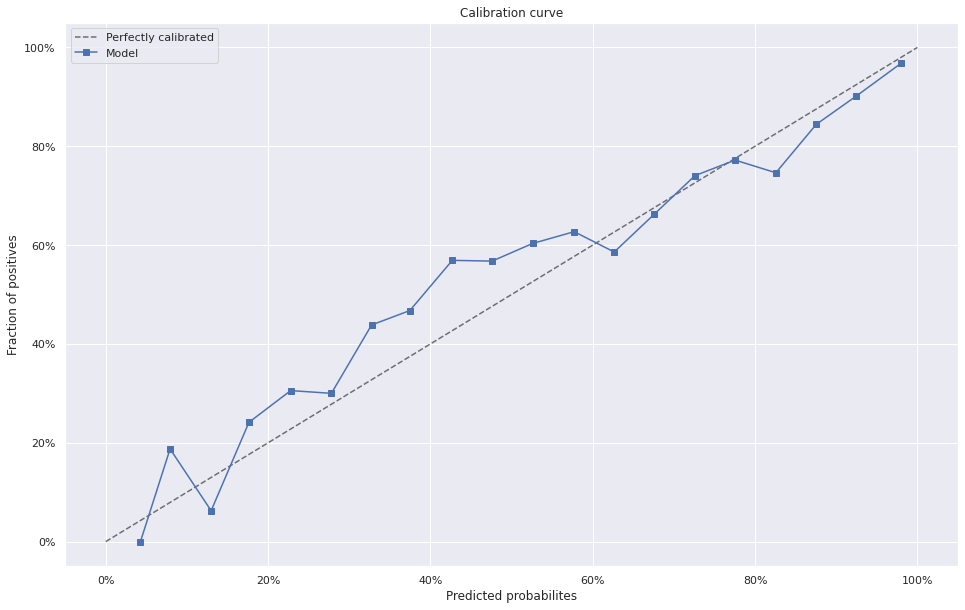

In [48]:
import matplotlib.ticker as mtick

from sklearn.calibration import calibration_curve

prob_pos = model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=20)

plt.figure(figsize=(16, 10))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated", alpha=0.6)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.ylabel("Fraction of positives")
plt.xlabel("Predicted probabilites")
plt.legend()
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.title("Calibration curve")
plt.show()

What we see is that from 40% onwards, the model contains the right proportions of both positive and negative observations: there is therefore no over-representation of a certain class when the predicted probabilities are above 40%.

Below this value, we observe some disparities, but which remain nevertheless controlled over the whole range of probabilities. In view of this curve, we can conclude that the proportions of positive classes are globally respected according to the predicted probabilities.

<a id="#conclusion-3"></a>    
## Conclusion

Hyperparameter optimization may take some effort at first, but once implemented, it is a real force for automation.

- We have seen the Bayesian approach to optimising the hyperparameters of a machine learning model.
- We optimised a LightGBM with a Tree of Parzen Estimators approach.
- The optimized model was saved in Pickle format for later re-use.

<a id="#validation-and-interpretability"></a>
# 4. Validation and interpretability

To ensure that once in production, the model behaves in a similar way to that encountered in the experimental phase, we need to use tools that allow us to audit it. Although the scores give an idea of the overall performance, they are not sufficient.

What we will do:
- Evaluate the performance of the model
- Interpret the model locally

<a id="#validate-the-model"></a>
## Validate the model

The first objectives of validation are to ensure that the calibrated model respects certain constraints that are not solely related to performance or score.

In [49]:
y_prob = model.predict_proba(X_test)

<a id="#class-densities"></a>
## Class densities

We have seen that the precision of our model was less good than the recall. In particular, with the calibration curve, we could observe that on predicted probabilities (positive class) lower than 40%, the proportions of really positive observations did not adopt a linear behaviour.

To better visualise this phenomenon, it is common to represent the densities of the two classes on a graph. Two histograms are displayed, corresponding to the positively and negatively predicted observations.

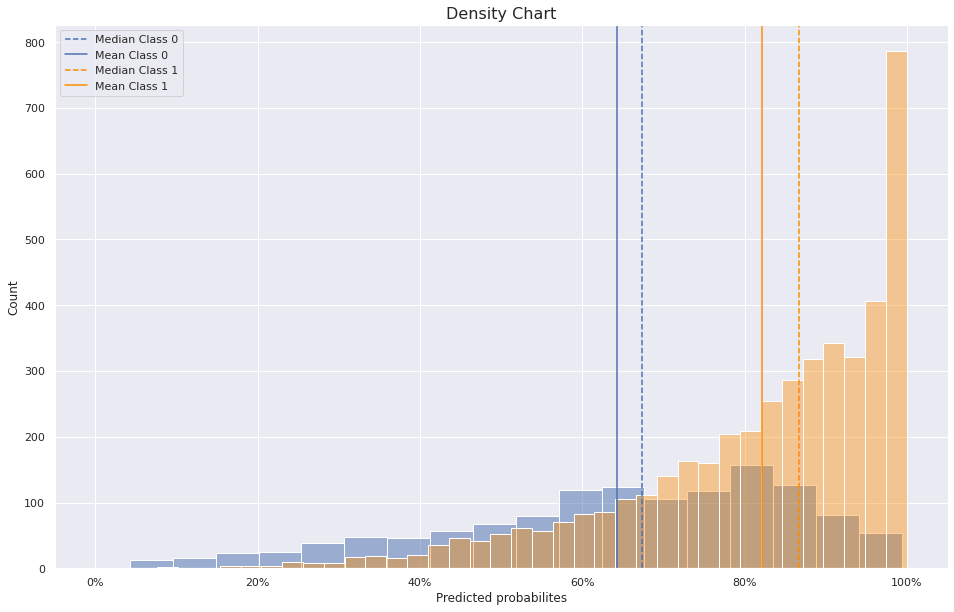

In [50]:
plt.figure(figsize=(16, 10))

sns.histplot(y_prob[y_test == 0, 1], alpha=0.5)
plt.axvline(np.median(y_prob[y_test == 0, 1]), 0,1, linestyle="--", label="Median Class 0")
plt.axvline(np.mean(y_prob[y_test == 0, 1]), 0,1, linestyle="-", label="Mean Class 0")

sns.histplot(y_prob[y_test == 1, 1], color="darkorange", alpha=0.4)
plt.axvline(np.median(y_prob[y_test == 1, 1]), 0, 1, linestyle="--", color="darkorange", label="Median Class 1")
plt.axvline(np.mean(y_prob[y_test == 1, 1]), 0, 1, linestyle="-", color="darkorange", label="Mean Class 1")

plt.legend()
plt.xlabel("Predicted probabilites")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.xlim(-0.05, 1.05)
plt.title("Density Chart", fontsize=16)
plt.show()

As a reminder, we had already calculated the calibration curve of the model.

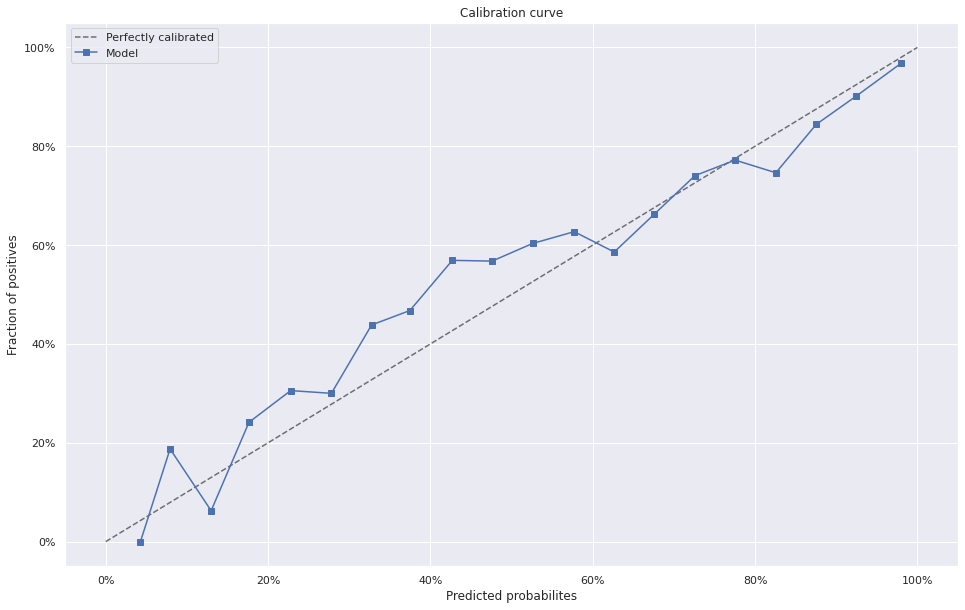

In [51]:
from sklearn.calibration import calibration_curve

prob_pos = model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=20)

plt.figure(figsize=(16, 10))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated", alpha=0.6)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.ylabel("Fraction of positives")
plt.xlabel("Predicted probabilites")
plt.legend()
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.title("Calibration curve")
plt.show()

Although the calibration curve is not shocking, we observe on the class densities that both distributions are asymmetric with a mean to the left of the median, reflecting a leftward spread. Although this is expected for the positive class, it is less expected for the negative class. Indeed, the latter should, for a perfect model, be spread to the right, so the majority of observations are on the left.

In itself, this graph does not block the validation of the model, it simply translates in a visual way that the model has more difficulties to predict with a high confidence low probabilities.

<a id="#roc-curve"></a>
## ROC curve

The ROC curve plots the sensitivity of the model against its specificity. In other words, __it plots the true positive rate__ against the false positive rate.

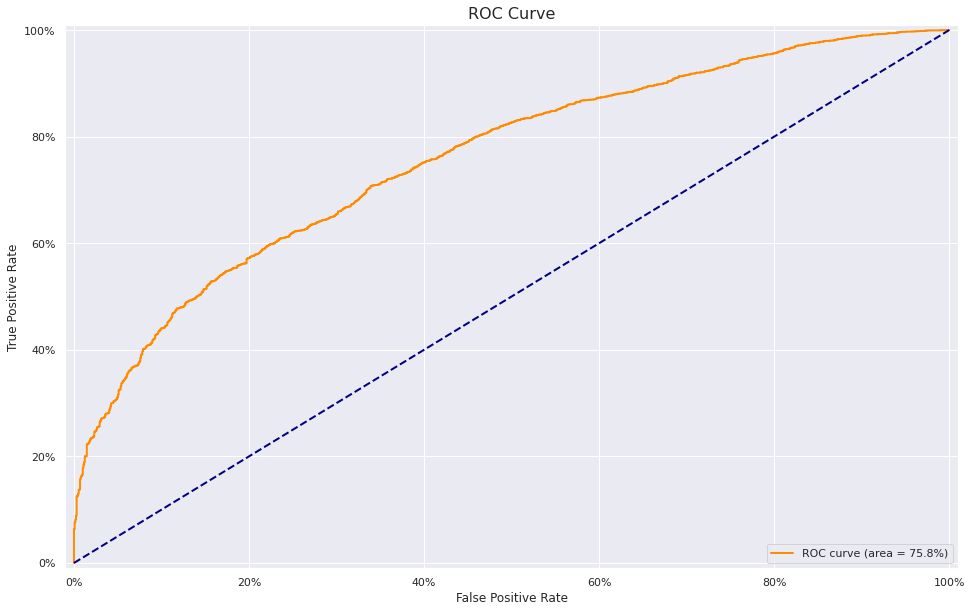

In [52]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(16, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:2.1f}%)'.format(auc(fpr, tpr) * 100))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.title("ROC Curve", fontsize=16)
plt.legend(loc="lower right")

In [53]:
# Print the AUC
print("The AUC: {}%".format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100, 2)))

The AUC: 75.83%


<a id="#precision-recall-curve"></a>    
## Precision-recall curve

Another curve also used is the PR curve, which will plot the evolution of precision as a function of recall.

The curve is even, which means that the predictions are made evenly on all data.


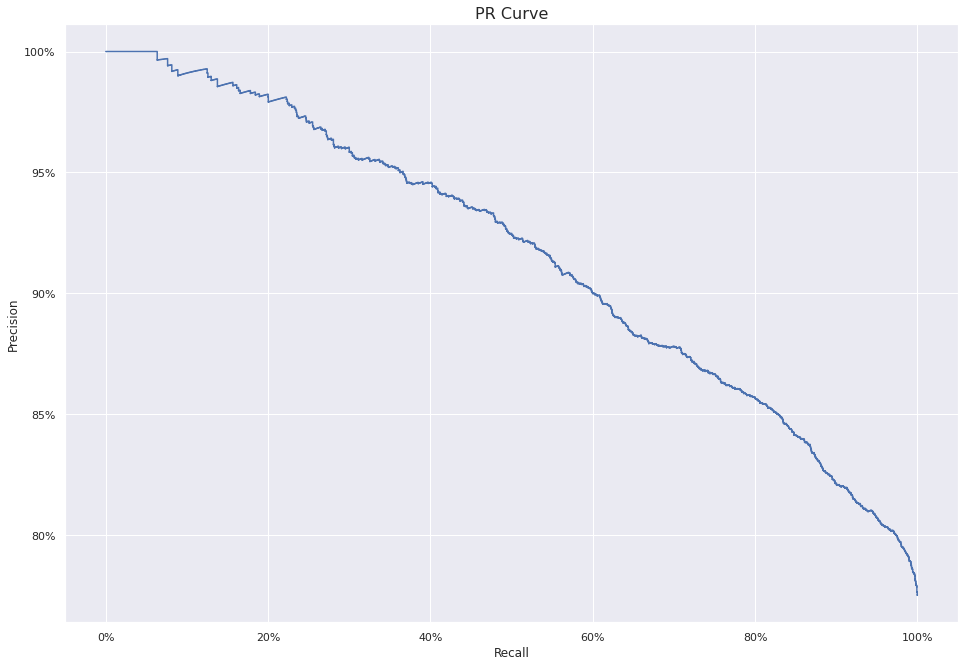

In [54]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

import matplotlib.pyplot as plt

y_pred = model.predict_proba(X_test)

plt.figure(figsize=(16,11))
prec, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=plt.gca())
plt.title("PR Curve", fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.show()

The main difference between ROC and PR curves is that precision and recall calculate rates from true positives without regard to true negatives. Precision does not intervene.\
Unlike the ROC curve, precision does not use the TPR, but the PPV! \
In contrast, the ROC curve uses all the information.

If we are not interested in specificity, then the PR curve can be interesting to interpret. If not, the ROC curve may provide more information.

<a id="#shapley-values"></a> 
## Shapley values

Shapley values provide a method of local interpretability: they allow us to answer the question "why does this user have a high probability of buying?

Shapley values have their origins in cooperative game theory. These values were calculated by Lloyd Shapley in 1953. Shapley values indicate the fair distribution of gains among the players (or actors) in a coalition in a cooperative game. 

<a id="#SHAP"></a>
## SHAP

In 2017, Scott Lundberg proposed SHAP as a unified measure of variable importance. His idea is as follows:

- We consider the variables to be the players.
- The total coalition represents the set of variables, and the payoff is the prediction of the model

Ideally, a Shapley value for a variable would tell us what its contribution to the prediction is. For example, a Shapley value close to 0 would mean that the variable did not have much impact on the prediction, while a high value would indicate that the variable has a strong impact on the price of housing.

With SHAP, we will be able to calculate these Shapley values (approximately or exactly for decision trees).

In [55]:
import shap

# Explainer object
explainer = shap.TreeExplainer(model)
X_shap = X_test.copy()

# We recover the Shapley values in the matrix (for the positive proba)
shap_values = explainer.shap_values(X_shap)[1]

To make it easier to interpret the Shapley values of an observation, we will break down each variable on a bar chart.

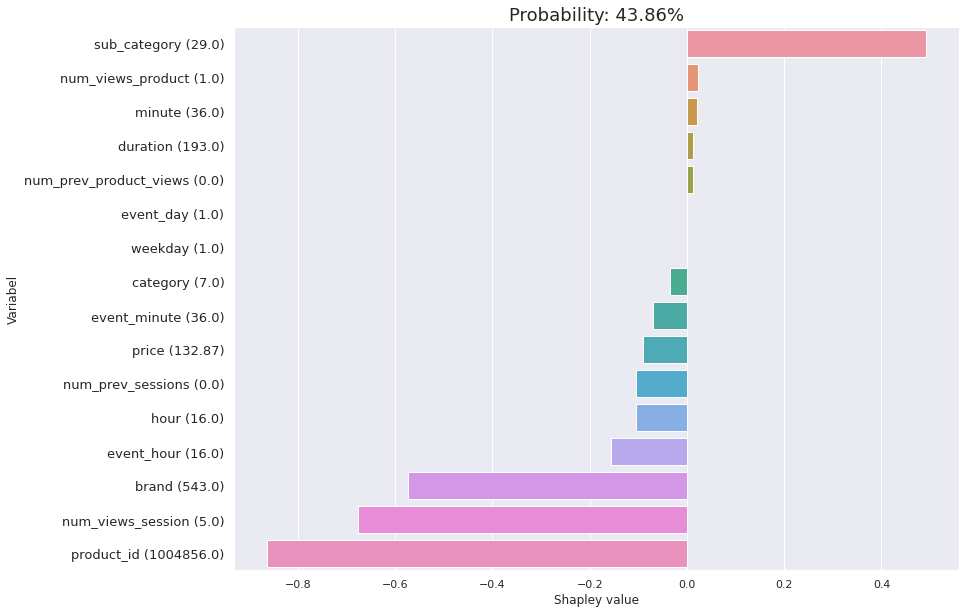

In [56]:
# This function displays the Shapley values as a bar chart
def plot_shapley_values(index):
    shap_df = pd.DataFrame.from_dict({
        'Variabel': X_shap.columns + " (" + X_shap.iloc[0, :].values.astype(str) + ")",
        'Shapley value': shap_values[index, :]
    })

    # As a reminder, the prediction is equal to the sum of the Shapley values + the mean value
    prob = explainer.expected_value[1] + shap_df['Shapley value'].sum()
    prob = 1 / (1 + np.exp(-prob))

    plt.figure(figsize=(13,10))
    sns.barplot(
        y='Variabel',
        x='Shapley value',
        data=shap_df.sort_values('Shapley value', ascending=False)
    )
    plt.title(
        "Probability: {:2.2f}%".format(prob * 100),
        fontsize=18
    )
    plt.yticks(fontsize=13)
    
plot_shapley_values(8)

Concerning the selected user, the model is undecided as it predicts almost 50/50. What we notice is that this particular product (product_id) contributes strongly to lowering the probability.

Let's look at another user.

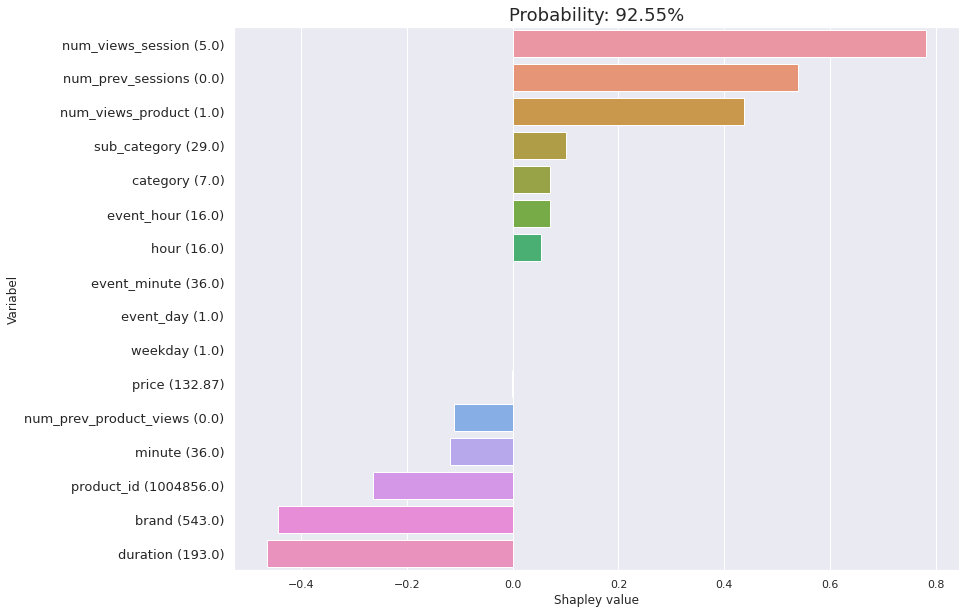

In [57]:
plot_shapley_values(1)

For this user, however, there is a very high probability of purchase. The most impactful variables are the number of views and number of sessions.

In some cases, it is possible to make a global interpretation by displaying the Shapley values of each variable and each observation.

The colour change indicates whether the variable has a high value or not. \
Red = high association

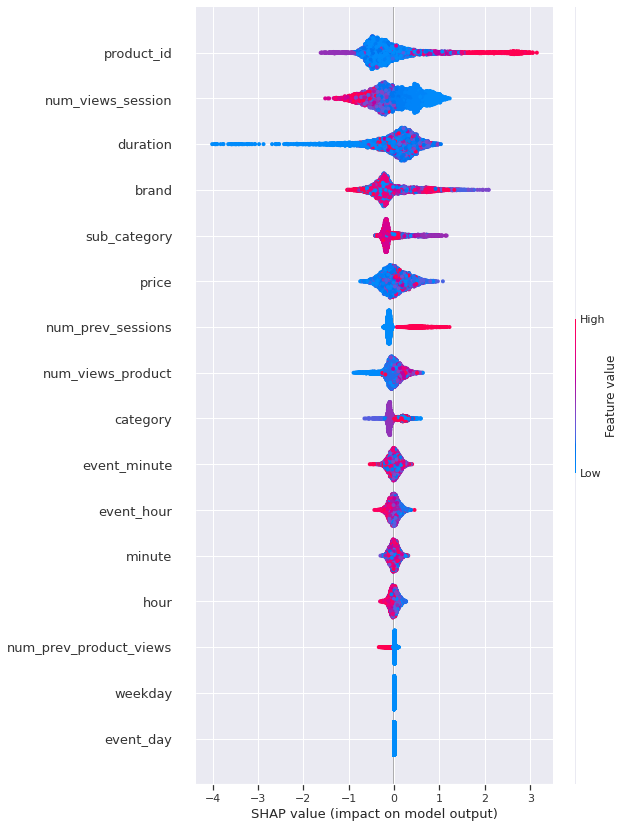

In [58]:
shap.summary_plot(shap_values, X_shap, plot_size=0.8)

While there is an increasing trend for **num_views_session** or **duration**, this is more difficult for product_id, brand or category, which is to be expected as we had done a dictionary encoding: there is therefore no order relationship between the variables.

Let's look in detail at the Shapley values for the **product_id** variable only.

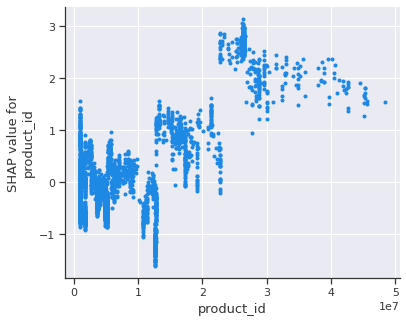

In [59]:
shap.dependence_plot("product_id", shap_values, X_shap, interaction_index=None)

It is interesting to see that certain tiers are formed: specifically between 2e7 and 3e7, there are certain products that positively influence the probability of buying, as their values rise to 4.

<blockquote style='padding:20px'>The Shapley value does not represent a probability! It is the calculation before going through the logistic function.</blockquote>

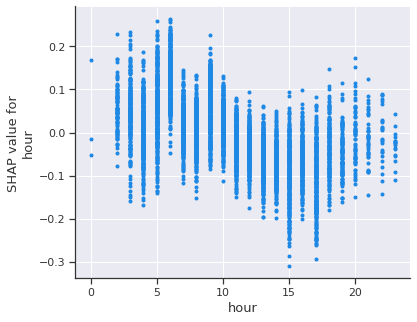

In [60]:
shap.dependence_plot("hour", shap_values, X_shap, interaction_index=None)

For the time of visit, we also observe a decreasing average behaviour between 5am and 5pm, then an increase until midnight. This decrease can be explained by the fact that from 5pm onwards, there are many more connections than in the middle of the night, and that these users are more often undecided than those visiting the site at night.

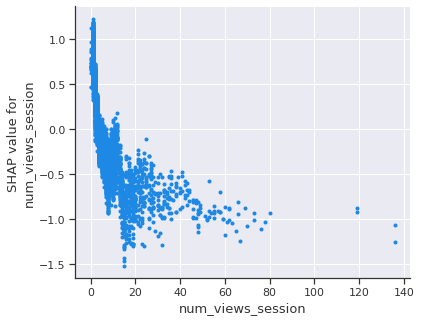

In [61]:
shap.dependence_plot("num_views_session", shap_values, X_shap, interaction_index=None)

Contrary to what we might think, Shapley values are high for low values of num_views_sessions. From 5 visits in the same session onwards, Shapley values are more diffuse but average around 0.5, thus lowering the probability slightly.

<blockquote style='padding:20px'>Always keep in mind that there are interactions between variables, and that having high Shapley values for low values cannot be summed up in this one variable.</blockquote>

<a id="#conclusion"></a>
# Conclusion

This validation step is important, since when we automate the training of the model, only these graphs and interpretations will allow us to verify that the model is really performing, and not only in terms of metrics.

- We have validated the model with the help of graphs.
- We interpreted locally some observations with Shapley values.